In [0]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

%matplotlib inline

## Train Set preprocesamiento


### FD001

In [0]:
#Creación dataframe train set para preprocesamiento 

df = pd.read_csv('train_FD001.txt', sep = ' ', header = None)
df = df.drop(columns=[26, 27])
df.columns = (["n_engine","cycle","opset_1","opset_2","opset_3",
              "sens_1","sens_2","sens_3","sens_4","sens_5","sens_6","sens_7","sens_8","sens_9","sens_10",
              "sens_11","sens_12","sens_13","sens_14","sens_15","sens_16","sens_17","sens_18","sens_19","sens_20","sens_21"])
df = df.drop(['sens_1','sens_5','sens_6','sens_10','sens_16','sens_18','sens_19'],axis=1)

In [0]:
#Agregada variable RUL a df y normalización de columnas (salvo RUL)
RUL_temp=np.zeros(0)
for i in range(1,df['n_engine'].max() + 1):
    minus = np.linspace(1,df[df['n_engine']==i]['cycle'].max(),df[df['n_engine']==i]['cycle'].max())
    RUL_engine = np.ones((df[df['n_engine']==i]['cycle'].max()))*df[df['n_engine']==i]['cycle'].max()
    RUL_temp = np.append(RUL_temp,RUL_engine-minus)
df['RUL'] = RUL_temp
df['RUL'] = df['RUL'].astype(int)
scaler = MinMaxScaler(feature_range=(-1,1))
df[df.columns[1:19]]= scaler.fit_transform(df[df.columns[1:19]])

In [4]:
#contenido dataframe df
df.iloc[0:30][:].head()

,n_engine,cycle,opset_1,opset_2,opset_3,sens_2,sens_3,sens_4,sens_7,sens_8,sens_9,sens_11,sens_12,sens_13,sens_14,sens_15,sens_17,sens_20,sens_21,RUL
0,1,-1.000000,-0.080460,-0.666667,-1.0,-0.632530,-0.186396,-0.380486,0.452496,-0.515152,-0.780490,-0.261905,0.266525,-0.588235,-0.600784,-0.272028,-0.333333,0.426357,0.449323,191
1,1,-0.994460,0.218391,-0.500000,-1.0,-0.433735,-0.093961,-0.294733,0.256039,-0.575758,-0.799515,-0.238095,0.530917,-0.441176,-0.674373,-0.177376,-0.333333,0.333333,0.462027,190
2,1,-0.988920,-0.494253,0.500000,-1.0,-0.313253,-0.260955,-0.258947,0.420290,-0.454545,-0.719914,-0.500000,0.590618,-0.558824,-0.656414,-0.285110,-0.666667,0.255814,0.242751,189
3,1,-0.983380,0.080460,0.000000,-1.0,-0.313253,-0.487683,-0.337610,0.481481,-0.363636,-0.750965,-0.666667,0.778252,-0.411765,-0.650222,-0.666795,-0.333333,0.147287,0.324772,188
4,1,-0.977839,-0.218391,-0.333333,-1.0,-0.301205,-0.485066,-0.190749,0.336554,-0.515152,-0.700081,-0.488095,0.492537,-0.529412,-0.650532,-0.195845,-0.166667,0.178295,0.409003,187


In [0]:
# Creación de features maps

features_maps=np.empty((30,14,1))
df_ys = np.zeros((1,1))
for i in range(1,df['n_engine'].max()+1):
  #se obtienen los dataset de engines independientes en df_temp
  df_temp1 = df[df['n_engine'] == i]
  df_temp2 = df_temp1.drop(['n_engine','cycle','opset_1','opset_2','opset_3'],axis=1)
  df_features = df_temp2.drop(['RUL'],axis = 1)
  df_y = df_temp2['RUL'].to_numpy()
  df_ys = np.append(df_ys,df_y[29:])
  for j in range(len(df_y)-29):
    feature_map = df_features[j:j+30][:]
    features_maps = np.dstack((features_maps, feature_map))
features_maps=np.delete(features_maps, 0, 2)
df_ys = np.delete(df_ys, 0, 0)

In [6]:
#Dimensiones feature maps y features maps apilados
print(features_maps.shape)
print(feature_map.shape)

(30, 14, 17731)
(30, 14)


In [7]:
# cambio de dimensión features maps de forma Ntimestaps,Nfeatures,M) a (M,Ntimestaps,Nfeatures)
print(df_ys.shape)
features_maps = np.moveaxis(features_maps, 2, 0)
print(features_maps.shape)

(17731,)
(17731, 30, 14)


In [8]:
# Expansion a 2 dimensiones para vector con Yverdaderos (RUL conjunto de entrenamiento) y 4 para features maps
df_ys = np.expand_dims(df_ys,axis=1)
features_maps= np.expand_dims(features_maps,3)
print(df_ys.shape)
print(features_maps.shape)

(17731, 1)
(17731, 30, 14, 1)


In [9]:
# Se barajan pares  (feature map, Yverdadero(RUL)) en forma aleatoria para evitar sesgo al comenzar
# el entreno de las ANN

from sklearn.utils import shuffle

features_maps, df_ys = shuffle(features_maps, df_ys, random_state=10)

# Todos los rul > a 125 se setean en 125 segun papers

for i in range(len(df_ys)):
  if df_ys[i] >= 125:
    df_ys[i] = 125
  else:
    df_ys[i] = df_ys[i]

print(df_ys)

# 

ys_train = df_ys[:int(len(df_ys)*0.9)]
ys_valid = df_ys[int(len(df_ys)*0.9):]

features_maps_train = features_maps[:int(len(df_ys)*0.9)]
features_maps_valid = features_maps[int(len(df_ys)*0.9):]

[[20.]
 [51.]
 [ 3.]
 ...
 [ 2.]
 [67.]
 [57.]]


### FD002

In [0]:
#Creación dataframe train set para preprocesamiento 

df = pd.read_csv('train_FD002.txt', sep = ' ', header = None)
df = df.drop(columns=[26, 27])
df.columns = (["n_engine","cycle","opset_1","opset_2","opset_3",
              "sens_1","sens_2","sens_3","sens_4","sens_5","sens_6","sens_7","sens_8","sens_9","sens_10",
              "sens_11","sens_12","sens_13","sens_14","sens_15","sens_16","sens_17","sens_18","sens_19","sens_20","sens_21"])
df = df.drop(['sens_1','sens_5','sens_6','sens_10','sens_16','sens_18','sens_19'],axis=1)

In [0]:
#Agregada variable RUL a df y normalización de columnas (salvo RUL)
RUL_temp=np.zeros(0)
for i in range(1,df['n_engine'].max() + 1):
    minus = np.linspace(1,df[df['n_engine']==i]['cycle'].max(),df[df['n_engine']==i]['cycle'].max())
    RUL_engine = np.ones((df[df['n_engine']==i]['cycle'].max()))*df[df['n_engine']==i]['cycle'].max()
    RUL_temp = np.append(RUL_temp,RUL_engine-minus)
df['RUL'] = RUL_temp
df['RUL'] = df['RUL'].astype(int)
scaler = MinMaxScaler(feature_range=(-1,1))
df[df.columns[1:19]]= scaler.fit_transform(df[df.columns[1:19]])

In [0]:
features_maps_2=np.empty((20,14,1))
df_ys_2 = np.zeros((1,1))
for i in range(1,df['n_engine'].max()+1):
  #se obtienen los dataset de engines independientes en df_temp
  df_temp1 = df[df['n_engine'] == i]
  df_temp2 = df_temp1.drop(['n_engine','cycle','opset_1','opset_2','opset_3'],axis=1)
  df_features = df_temp2.drop(['RUL'],axis = 1)
  df_y = df_temp2['RUL'].to_numpy()
  df_ys_2 = np.append(df_ys_2,df_y[19:])
  for j in range(len(df_y)-19):
    feature_map = df_features[j:j+20][:]
    features_maps_2 = np.dstack((features_maps_2, feature_map))
features_maps_2=np.delete(features_maps_2, 0, 2)
df_ys_2 = np.delete(df_ys_2, 0, 0)

In [44]:
#Dimensiones feature maps y features maps_2 apilados
print(features_maps_2.shape)
print(feature_map.shape)

(20, 14, 48819)
(20, 14)


In [45]:
# cambio de dimensión features maps de forma Ntimestaps,Nfeatures,M) a (M,Ntimestaps,Nfeatures)
print(df_ys_2.shape)
features_maps_2 = np.moveaxis(features_maps_2, 2, 0)
print(features_maps_2.shape)

(48819,)
(48819, 20, 14)


In [46]:
# Expansion a 2 dimensiones para vector con Yverdaderos (RUL conjunto de entrenamiento) y 4 para features maps
df_ys_2 = np.expand_dims(df_ys_2,axis=1)
features_maps_2= np.expand_dims(features_maps_2,3)
print(df_ys_2.shape)
print(features_maps_2.shape)

(48819, 1)
(48819, 20, 14, 1)


In [47]:
features_maps_2, df_ys_2 = shuffle(features_maps_2, df_ys_2, random_state=10)

# Todos los rul > a 125 se setean en 125 segun papers

for i in range(len(df_ys_2)):
  if df_ys_2[i] >= 125:
    df_ys_2[i] = 125
  else:
    df_ys_2[i] = df_ys_2[i]

print(df_ys_2)

# 

ys_train_2 = df_ys_2[:int(len(df_ys_2)*0.9)]
ys_valid_2 = df_ys_2[int(len(df_ys_2)*0.9):]

features_maps_train_2 = features_maps_2[:int(len(df_ys_2)*0.9)]
features_maps_valid_2 = features_maps_2[int(len(df_ys_2)*0.9):]

[[ 37.]
 [125.]
 [125.]
 ...
 [125.]
 [ 65.]
 [112.]]


### FD003

In [0]:
#Creación dataframe train set para preprocesamiento 

df = pd.read_csv('train_FD003.txt', sep = ' ', header = None)
df = df.drop(columns=[26, 27])
df.columns = (["n_engine","cycle","opset_1","opset_2","opset_3",
              "sens_1","sens_2","sens_3","sens_4","sens_5","sens_6","sens_7","sens_8","sens_9","sens_10",
              "sens_11","sens_12","sens_13","sens_14","sens_15","sens_16","sens_17","sens_18","sens_19","sens_20","sens_21"])
df = df.drop(['sens_1','sens_5','sens_6','sens_10','sens_16','sens_18','sens_19'],axis=1)

In [0]:
#Agregada variable RUL a df y normalización de columnas (salvo RUL)
RUL_temp=np.zeros(0)
for i in range(1,df['n_engine'].max() + 1):
    minus = np.linspace(1,df[df['n_engine']==i]['cycle'].max(),df[df['n_engine']==i]['cycle'].max())
    RUL_engine = np.ones((df[df['n_engine']==i]['cycle'].max()))*df[df['n_engine']==i]['cycle'].max()
    RUL_temp = np.append(RUL_temp,RUL_engine-minus)
df['RUL'] = RUL_temp
df['RUL'] = df['RUL'].astype(int)
scaler = MinMaxScaler(feature_range=(-1,1))
df[df.columns[1:19]]= scaler.fit_transform(df[df.columns[1:19]])

In [0]:
features_maps_3=np.empty((30,14,1))
df_ys_3 = np.zeros((1,1))
for i in range(1,df['n_engine'].max()+1):
  #se obtienen los dataset de engines independientes en df_temp
  df_temp1 = df[df['n_engine'] == i]
  df_temp2 = df_temp1.drop(['n_engine','cycle','opset_1','opset_2','opset_3'],axis=1)
  df_features = df_temp2.drop(['RUL'],axis = 1)
  df_y = df_temp2['RUL'].to_numpy()
  df_ys_3 = np.append(df_ys_3,df_y[29:])
  for j in range(len(df_y)-29):
    feature_map = df_features[j:j+30][:]
    features_maps_3 = np.dstack((features_maps_3, feature_map))
features_maps_3=np.delete(features_maps_3, 0, 2)
df_ys_3 = np.delete(df_ys_3, 0, 0)

In [0]:
print(features_maps_3.shape)
print(feature_map.shape)

## Test set

### FD001

In [0]:
df_t = pd.read_csv('test_FD001.txt', sep = ' ', header = None)
df_t = df_t.drop(columns=[26, 27])
df_t.columns = (["n_engine","cycle","opset_1","opset_2","opset_3",
              "sens_1","sens_2","sens_3","sens_4","sens_5","sens_6","sens_7","sens_8","sens_9","sens_10",
              "sens_11","sens_12","sens_13","sens_14","sens_15","sens_16","sens_17","sens_18","sens_19","sens_20","sens_21"])
df_t = df_t.drop(['sens_1','sens_5','sens_6','sens_10','sens_16','sens_18','sens_19'],axis=1)
df_t[df_t.columns[1:19]]= scaler.transform(df_t[df_t.columns[1:19]])

In [11]:
ruls_test= []
rul_file = open("RUL_FD001.txt", "r")
for rul_line in rul_file:
  ruls_test.append(int(rul_line.rstrip(' \n')))
print(ruls_test)


[112, 98, 69, 82, 91, 93, 91, 95, 111, 96, 97, 124, 95, 107, 83, 84, 50, 28, 87, 16, 57, 111, 113, 20, 145, 119, 66, 97, 90, 115, 8, 48, 106, 7, 11, 19, 21, 50, 142, 28, 18, 10, 59, 109, 114, 47, 135, 92, 21, 79, 114, 29, 26, 97, 137, 15, 103, 37, 114, 100, 21, 54, 72, 28, 128, 14, 77, 8, 121, 94, 118, 50, 131, 126, 113, 10, 34, 107, 63, 90, 8, 9, 137, 58, 118, 89, 116, 115, 136, 28, 38, 20, 85, 55, 128, 137, 82, 59, 117, 20]


In [0]:
features_maps_test=np.empty((30,14,1))
for i in range(1,df_t['n_engine'].max()+1):
  #se obtienen los dataset de engines independientes en df_temp
  df_temp = df_t[df_t['n_engine'] == i].drop(['n_engine','cycle','opset_1','opset_2','opset_3'],axis=1)
  df_large = df_temp['sens_8'].count()
  feature_map = df_temp[df_large-30:][:]
  features_maps_test = np.dstack((features_maps_test, feature_map))
features_maps_test=np.delete(features_maps_test, 0, 2)

In [13]:
print(features_maps_test.shape)
print(feature_map.shape)

(30, 14, 100)
(30, 14)


In [14]:
features_maps_test = np.moveaxis(features_maps_test, 2, 0)
print(features_maps_test.shape)

(100, 30, 14)


In [15]:
features_maps_test= np.expand_dims(features_maps_test,3)
print(features_maps_test.shape)

(100, 30, 14, 1)


In [16]:
list1 = np.array(ruls_test)
list2 = np.array(features_maps_test)
idx   = np.argsort(list1)

list1 = np.array(list1)[idx]
list2 = np.array(list2)[idx]

for i in range(len(list1)):
  if list1[i] >= 125:
    list1[i] = 125
  else:
    list1[i] = list1[i]

print(list1)

[  7   8   8   8   9  10  10  11  14  15  16  18  19  20  20  20  21  21
  21  26  28  28  28  28  29  34  37  38  47  48  50  50  50  54  55  57
  58  59  59  63  66  69  72  77  79  82  82  83  84  85  87  89  90  90
  91  91  92  93  94  95  95  96  97  97  97  98 100 103 106 107 107 109
 111 111 112 113 113 114 114 114 115 115 116 117 118 118 119 121 124 125
 125 125 125 125 125 125 125 125 125 125]


### FD002

In [0]:
df_t = pd.read_csv('test_FD002.txt', sep = ' ', header = None)
df_t = df_t.drop(columns=[26, 27])
df_t.columns = (["n_engine","cycle","opset_1","opset_2","opset_3",
              "sens_1","sens_2","sens_3","sens_4","sens_5","sens_6","sens_7","sens_8","sens_9","sens_10",
              "sens_11","sens_12","sens_13","sens_14","sens_15","sens_16","sens_17","sens_18","sens_19","sens_20","sens_21"])
df_t = df_t.drop(['sens_1','sens_5','sens_6','sens_10','sens_16','sens_18','sens_19'],axis=1)
df_t[df_t.columns[1:19]]= scaler.transform(df_t[df_t.columns[1:19]])

In [0]:
ruls_test= []
rul_file = open("RUL_FD002.txt", "r")
for rul_line in rul_file:
  ruls_test.append(int(rul_line.rstrip(' \n')))

In [0]:
features_maps_test=np.empty((20,14,1))
for i in range(1,df_t['n_engine'].max()+1):
  #se obtienen los dataset de engines independientes en df_temp
  df_temp = df_t[df_t['n_engine'] == i].drop(['n_engine','cycle','opset_1','opset_2','opset_3'],axis=1)
  df_large = df_temp['sens_8'].count()
  feature_map = df_temp[df_large-20:][:]
  features_maps_test = np.dstack((features_maps_test, feature_map))
features_maps_test=np.delete(features_maps_test, 0, 2)

In [94]:
print(features_maps_test.shape)
print(feature_map.shape)

(20, 14, 259)
(20, 14)


In [95]:
features_maps_test = np.moveaxis(features_maps_test, 2, 0)
print(features_maps_test.shape)

(259, 20, 14)


In [96]:
features_maps_test= np.expand_dims(features_maps_test,3)
print(features_maps_test.shape)

(259, 20, 14, 1)


In [97]:
list1_2 = np.array(ruls_test)
list2_2 = np.array(features_maps_test)
idx   = np.argsort(list1_2)

list1_2 = np.array(list1_2)[idx]
list2_2 = np.array(list2_2)[idx]

for i in range(len(list1_2)):
  if list1_2[i] >= 125:
    list1_2[i] = 125
  else:
    list1_2[i] = list1_2[i]

print(list1_2)

[  6   6   6   6   6   7   7   7   8   8   8   8   8   8   9   9   9   9
   9  10  10  10  11  11  11  11  11  11  12  12  12  13  13  13  13  14
  14  14  14  14  14  15  15  15  15  15  16  17  17  17  18  18  19  21
  22  23  23  23  26  27  30  31  32  34  35  35  36  36  37  37  37  38
  39  39  39  41  42  43  43  43  44  47  47  48  48  48  49  50  51  51
  52  52  53  53  54  55  55  56  56  56  57  59  61  61  62  63  67  67
  67  68  68  68  73  73  73  73  73  74  75  75  77  78  78  78  79  79
  79  79  80  80  81  81  82  82  83  83  83  84  85  85  86  86  86  87
  88  88  88  89  90  91  91  92  93  94  95  96  97  97  97  97  97  98
  98  98  99  99 100 101 101 101 103 103 103 104 106 106 106 106 106 107
 108 108 108 110 111 111 112 115 115 116 120 120 121 121 121 121 121 122
 122 122 123 124 125 125 125 125 125 125 125 125 125 125 125 125 125 125
 125 125 125 125 125 125 125 125 125 125 125 125 125 125 125 125 125 125
 125 125 125 125 125 125 125 125 125 125 125 125 12

# CNN 

Propuesta de Li, Ding, Sun

![Imagen](https://github.com/farayal/memoria_turbofan/blob/master/cnn_regression.png?raw=true)

In [17]:
from keras import layers
from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D
from keras.layers import AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D
from keras.models import Model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
from keras import regularizers

import keras.backend as K
K.set_image_data_format('channels_last')


Using TensorFlow backend.


In [0]:
def cnnturbofan(input_shape):
   
    X_input = Input(input_shape)

    #Layer 1
    # Zero-Padding: Para originar un output (20,14) en la siguiente capa
    #X = ZeroPadding2D((5, 0))(X_input)

    # CONV -> TANH aplicado a X
    X = Conv2D(10, (10, 1), strides = (1, 1),padding='same', name = 'conv0')(X_input)
    #X = BatchNormalization(axis = 3, name = 'bn0')(X)
    X = Activation('tanh')(X)

    #Layer 2
    #X = ZeroPadding2D((4, 0))(X)
    X = Conv2D(10, (10, 1), strides = (1, 1), padding = 'same', name = 'conv1')(X)
    #X = BatchNormalization(axis = 3, name = 'bn1')(X)
    X = Activation('tanh')(X)

    #Layer 3
    #X = ZeroPadding2D((5, 0))(X)
    X = Conv2D(10, (10, 1), strides = (1, 1), padding='same', name = 'conv2')(X)
    #X = BatchNormalization(axis = 3, name = 'bn2')(X)
    X = Activation('tanh')(X)

    #Layer 4
    #X = ZeroPadding2D((4, 0))(X)
    X = Conv2D(10, (10, 1), strides = (1, 1),padding='same', name = 'conv3')(X)
    #X = BatchNormalization(axis = 3, name = 'bn3')(X)
    X = Activation('tanh')(X)

    #Layer 5
    #X = ZeroPadding2D((1, 0))(X)
    X = Conv2D(1, (3, 1), strides = (1, 1),padding='same', name = 'conv4')(X)
    #X = BatchNormalization(axis = 3, name = 'bn4')(X)
    X = Activation('tanh')(X)

    # FLATTEN X ("desenrollamos el feature map anterior") + FULLYCONNECTED
    X = Flatten()(X)
    X = Dropout(0.5)(X)
    #X = BatchNormalization(name='bn5')(X)
    X = Dense(100, activation='tanh', name='fully-connected')(X)
    #X = Dropout(0.5)(X)
    #X = BatchNormalization(name='bn6')(X)
    X = Dense(1, name = 'rul-neuron')(X)

    # instancia modelo final
    model = Model(inputs = X_input, outputs = X, name='cnnturbofan')
    
  
    return model

In [19]:
cnnturbofan = cnnturbofan((features_maps.shape[1],features_maps.shape[2],features_maps.shape[3]))





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [20]:
def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true))) 

cnnturbofan.compile(optimizer = "Adam", loss = "mean_squared_error" , metrics = [root_mean_squared_error])

In [21]:
history = cnnturbofan.fit(x = features_maps_train, y = ys_train ,batch_size=512, epochs = 250 ,validation_data=(features_maps_valid,ys_valid))




Train on 15957 samples, validate on 1774 samples
Epoch 1/250





15957/15957 [==============================] - 4s 238us/step - loss: 6645.1189 - root_mean_squared_error: 81.4039 - val_loss: 6178.6687 - val_root_mean_squared_error: 78.5917
Epoch 2/250
15957/15957 [==============================] - 0s 28us/step - loss: 5707.1282 - root_mean_squared_error: 75.5306 - val_loss: 5698.6991 - val_root_mean_squared_error: 75.4759
Epoch 3/250
15957/15957 [==============================] - 0s 27us/step - loss: 5276.8826 - root_mean_squared_error: 72.6331 - val_loss: 5284.9988 - val_root_mean_squared_error: 72.6841
Epoch 4/250
15957/15957 [==============================] - 0s 28us/step - loss: 4895.3345 - root_mean_squared_error: 69.9540 - val_loss: 4910.8284 - val_root_mean_squared_error: 70.0633
Epoch 5/250
15957/15957 [==============================] - 0s 28us/step - loss: 4546.3436 - root_mean_squared_error: 67.4126 - val_loss: 4566.3503 - val_root_mean_squared_error: 67.5607
Epoch 6/250


In [22]:
cnnturbofan.summary()

Model: "cnnturbofan"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 30, 14, 1)         0         
_________________________________________________________________
conv0 (Conv2D)               (None, 30, 14, 10)        110       
_________________________________________________________________
activation_1 (Activation)    (None, 30, 14, 10)        0         
_________________________________________________________________
conv1 (Conv2D)               (None, 30, 14, 10)        1010      
_________________________________________________________________
activation_2 (Activation)    (None, 30, 14, 10)        0         
_________________________________________________________________
conv2 (Conv2D)               (None, 30, 14, 10)        1010      
_________________________________________________________________
activation_3 (Activation)    (None, 30, 14, 10)        

In [0]:
hola = cnnturbofan.predict(features_maps)

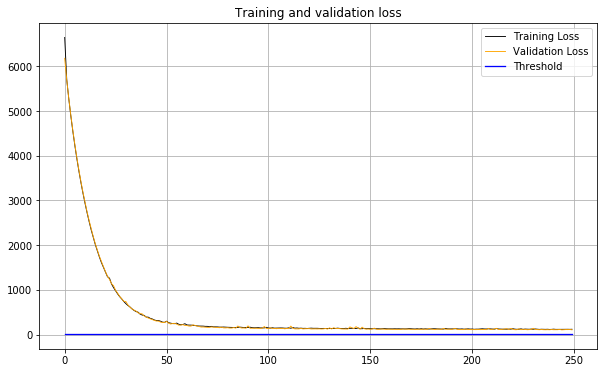

In [24]:
#acc = history.history['mean_absolute_error']
#val_acc = history.history['val_mean_absolute_error']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

##plt.plot(epochs, acc, 'r', label='Training accuracy')
#plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
#plt.title('Training and validation accuracy')
#plt.legend()
#plt.figure()

plt.figure(figsize=(10,6))
plt.grid(True) 
plt.plot(epochs, loss, 'black',lw=0.9, label='Training Loss')
plt.plot(epochs, val_loss, 'orange',lw=0.9, label='Validation Loss')
plt.plot(epochs, np.ones(len(epochs))*12.2, 'blue',lw=1.3,label='Threshold')
plt.title('Training and validation loss')
plt.legend()
  

plt.show()

In [0]:
holi = cnnturbofan.predict(list2)

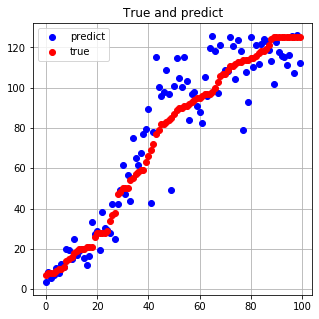

In [26]:
leng = range(100)

#plt.plot(leng, acc, 'r', label='Training accuracy')
#plt.plot(leng, val_acc, 'b', label='Validation accuracy')
#plt.title('Training and validation accuracy')
#plt.legend()
#plt.figure()

plt.figure(figsize=(5,5))
plt.grid(True) 
plt.plot(leng, holi, 'bo',lw=0.9, label='predict')
plt.plot(leng, list1, 'ro',lw=0.9, label='true')
plt.title('True and predict')
plt.legend()
  

plt.show()

In [27]:
from sklearn.metrics import mean_squared_error
from math import sqrt

rmse = sqrt(mean_squared_error(holi, list1))
print(rmse)

12.783120027471686


### FD002

In [0]:
def cnnturbofan(input_shape):
   
    X_input = Input(input_shape)

    #Layer 1
    # Zero-Padding: Para originar un output (20,14) en la siguiente capa
    #X = ZeroPadding2D((5, 0))(X_input)

    # CONV -> TANH aplicado a X
    X = Conv2D(10, (10, 1), strides = (1, 1),padding='same', name = 'conv0')(X_input)
    #X = BatchNormalization(axis = 3, name = 'bn0')(X)
    X = Activation('tanh')(X)

    #Layer 2
    #X = ZeroPadding2D((4, 0))(X)
    X = Conv2D(10, (10, 1), strides = (1, 1), padding = 'same', name = 'conv1')(X)
    #X = BatchNormalization(axis = 3, name = 'bn1')(X)
    X = Activation('tanh')(X)

    #Layer 3
    #X = ZeroPadding2D((5, 0))(X)
    X = Conv2D(10, (10, 1), strides = (1, 1), padding='same', name = 'conv2')(X)
    #X = BatchNormalization(axis = 3, name = 'bn2')(X)
    X = Activation('tanh')(X)

    #Layer 4
    #X = ZeroPadding2D((4, 0))(X)
    X = Conv2D(10, (10, 1), strides = (1, 1),padding='same', name = 'conv3')(X)
    #X = BatchNormalization(axis = 3, name = 'bn3')(X)
    X = Activation('tanh')(X)

    #Layer 5
    #X = ZeroPadding2D((1, 0))(X)
    X = Conv2D(1, (3, 1), strides = (1, 1),padding='same', name = 'conv4')(X)
    #X = BatchNormalization(axis = 3, name = 'bn4')(X)
    X = Activation('tanh')(X)

    # FLATTEN X ("desenrollamos el feature map anterior") + FULLYCONNECTED
    X = Flatten()(X)
    X = Dropout(0.5)(X)
    #X = BatchNormalization(name='bn5')(X)
    X = Dense(100, activation='tanh', name='fully-connected')(X)
    #X = Dropout(0.5)(X)
    #X = BatchNormalization(name='bn6')(X)
    X = Dense(1, name = 'rul-neuron')(X)

    # instancia modelo final
    model = Model(inputs = X_input, outputs = X, name='cnnturbofan')
    
  
    return model

In [0]:
cnnturbofan_2 = cnnturbofan((features_maps_2.shape[1],features_maps_2.shape[2],features_maps_2.shape[3]))

In [0]:
def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true))) 

cnnturbofan_2.compile(optimizer = "Adam", loss = "mean_squared_error" , metrics = [root_mean_squared_error])

In [84]:
history_2 = cnnturbofan_2.fit(x = features_maps_train_2, y = ys_train_2 ,batch_size=512, epochs = 250 ,validation_data=(features_maps_valid_2,ys_valid_2))

Train on 43937 samples, validate on 4882 samples
Epoch 1/250
43937/43937 [==============================] - 2s 37us/step - loss: 6707.1622 - root_mean_squared_error: 81.7715 - val_loss: 5871.5438 - val_root_mean_squared_error: 76.5986
Epoch 2/250
43937/43937 [==============================] - 1s 22us/step - loss: 5337.1741 - root_mean_squared_error: 73.0170 - val_loss: 4857.9983 - val_root_mean_squared_error: 69.6735
Epoch 3/250
43937/43937 [==============================] - 1s 21us/step - loss: 4439.4731 - root_mean_squared_error: 66.5980 - val_loss: 4062.4481 - val_root_mean_squared_error: 63.7139
Epoch 4/250
43937/43937 [==============================] - 1s 22us/step - loss: 3734.5921 - root_mean_squared_error: 61.0844 - val_loss: 3439.3259 - val_root_mean_squared_error: 58.6255
Epoch 5/250
43937/43937 [==============================] - 1s 21us/step - loss: 3186.0536 - root_mean_squared_error: 56.4259 - val_loss: 2958.5192 - val_root_mean_squared_error: 54.3758
Epoch 6/250
43937/439

In [85]:
cnnturbofan_2.summary()

Model: "cnnturbofan"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 20, 14, 1)         0         
_________________________________________________________________
conv0 (Conv2D)               (None, 20, 14, 10)        110       
_________________________________________________________________
activation_11 (Activation)   (None, 20, 14, 10)        0         
_________________________________________________________________
conv1 (Conv2D)               (None, 20, 14, 10)        1010      
_________________________________________________________________
activation_12 (Activation)   (None, 20, 14, 10)        0         
_________________________________________________________________
conv2 (Conv2D)               (None, 20, 14, 10)        1010      
_________________________________________________________________
activation_13 (Activation)   (None, 20, 14, 10)        

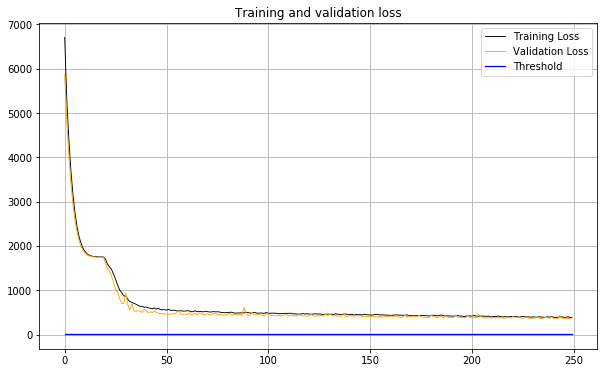

In [86]:
#acc = history.history['mean_absolute_error']
#val_acc = history.history['val_mean_absolute_error']
loss = history_2.history['loss']
val_loss = history_2.history['val_loss']

epochs = range(len(loss))

##plt.plot(epochs, acc, 'r', label='Training accuracy')
#plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
#plt.title('Training and validation accuracy')
#plt.legend()
#plt.figure()

plt.figure(figsize=(10,6))
plt.grid(True) 
plt.plot(epochs, loss, 'black',lw=0.9, label='Training Loss')
plt.plot(epochs, val_loss, 'orange',lw=0.9, label='Validation Loss')
plt.plot(epochs, np.ones(len(epochs))*12.2, 'blue',lw=1.3,label='Threshold')
plt.title('Training and validation loss')
plt.legend()
  

plt.show()

In [0]:
holi_2 = cnnturbofan_2.predict(list2_2)

In [102]:
print(len(holi_2))
print(len(list1_2))

259
259


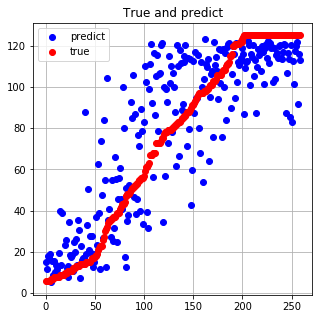

In [103]:
leng = range(259)

#plt.plot(leng, acc, 'r', label='Training accuracy')
#plt.plot(leng, val_acc, 'b', label='Validation accuracy')
#plt.title('Training and validation accuracy')
#plt.legend()
#plt.figure()

plt.figure(figsize=(5,5))
plt.grid(True) 
plt.plot(leng, holi_2, 'bo',lw=0.9, label='predict')
plt.plot(leng, list1_2, 'ro',lw=0.9, label='true')
plt.title('True and predict')
plt.legend()
  

plt.show()

In [104]:
rmse_2 = sqrt(mean_squared_error(holi_2, list1_2))
print(rmse_2)

21.71992150526042
